# 1. Data Cleaning
## Importation des données


In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("Market.xlsx", sheet_name="Market")
print(df.columns)


Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'age', 'spent', 'children', 'family_size', 'living_with', 'is_parent',
       'education2', 'customer_for'],
      dtype='object')


## Nettoyage des données
Remplacement des valeurs manquantes dans la colonne `Income` par la **moyenne** des revenus existants.  
Cela permet d’éviter la perte de données tout en gardant la cohérence du jeu de données.  
Après cette étape, le fichier nettoyé est enregistré sous le nom **Market_filled.xlsx** pour être utilisé dans les prochaines analyses.

In [15]:
from sklearn.impute import SimpleImputer
import pandas as pd

imputer = SimpleImputer(strategy='mean')
df[['Income']] = imputer.fit_transform(df[['Income']])

print(df['Income'].isnull().sum())

df.to_excel("Market_filled.xlsx", index=False)
print("✅ Fichier enregistré avec succès.")


0
✅ Fichier enregistré avec succès.


# 2. Analyse descriptive

In [ ]:
variables = ['age', 'spent', 'family_size', 'customer_for']

stats = {
    'Variable': [],
    'Moyenne': [],
    'Médiane': [],
    'Minimum': [],
    'Maximum': []
}
for var in variables:
    stats['Variable'].append(var)
    stats['Moyenne'].append(round(df[var].mean(), 2))
    stats['Médiane'].append(round(df[var].median(), 2))
    stats['Minimum'].append(round(df[var].min(), 2))
    stats['Maximum'].append(round(df[var].max(), 2))

summary_df = pd.DataFrame(stats)

print(summary_df)
summary_df.to_excel("Tableau_Analyse_Descriptive.xlsx", index=False)


       Variable  Moyenne  Médiane  Minimum  Maximum
0           age    56.10     55.0       29       85
1         spent   605.74    396.0        5     2525
2   family_size     2.60      3.0        1        5
3  customer_for   353.79    356.0        0      699


On observe une clientèle plutôt mature, avec un âge moyen d’environ 56 ans.
Les dépenses moyennes (« spent ») s’élèvent à environ 600 unités, mais la médiane à 396 suggère une distribution asymétrique, où une minorité de clients dépense beaucoup plus que la majorité.
La taille moyenne des foyers est d’environ 2,6 personnes, ce qui correspond à un couple avec ou sans enfant.
Enfin, la variable « customer_for » montre une ancienneté moyenne d’environ 354 jours, signe que la base inclut à la fois des nouveaux clients et des fidèles historiques.

# 3. Data Exploratory

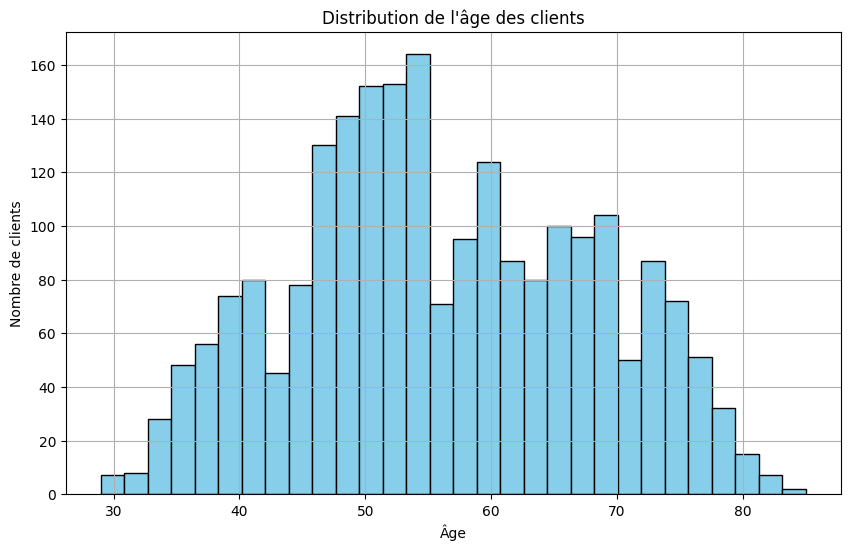

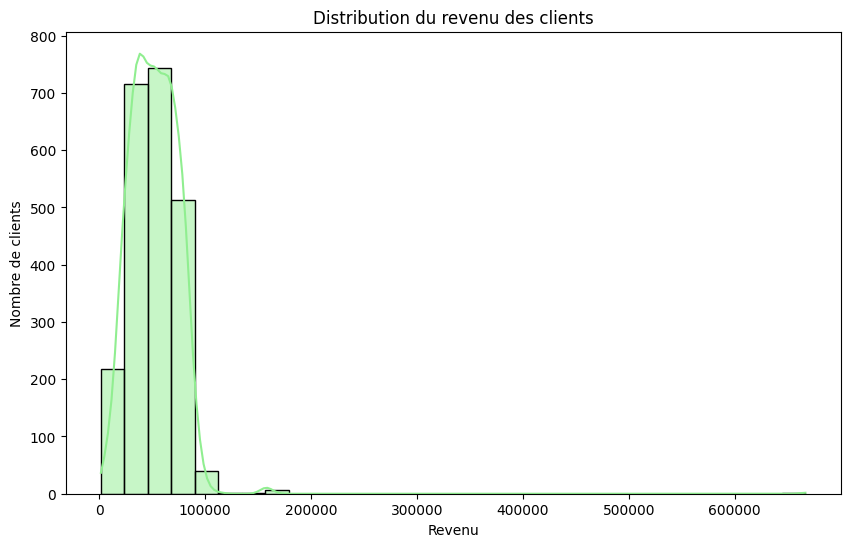

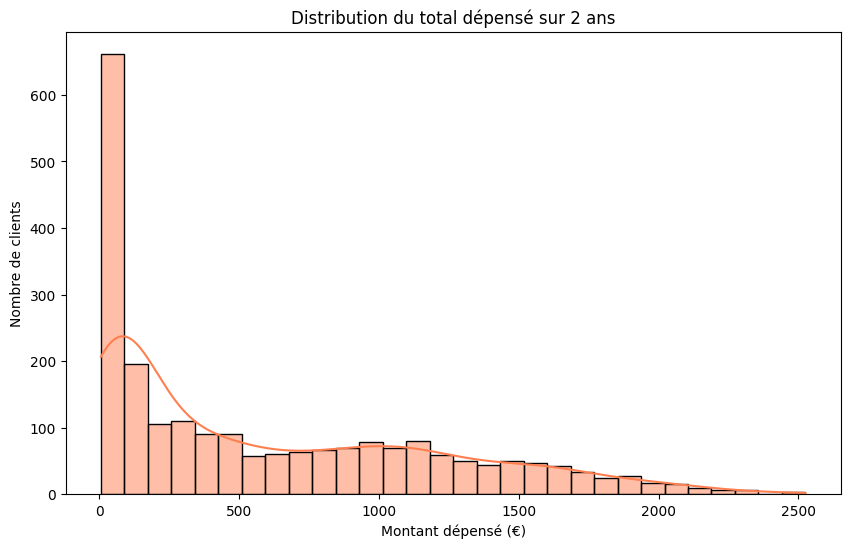

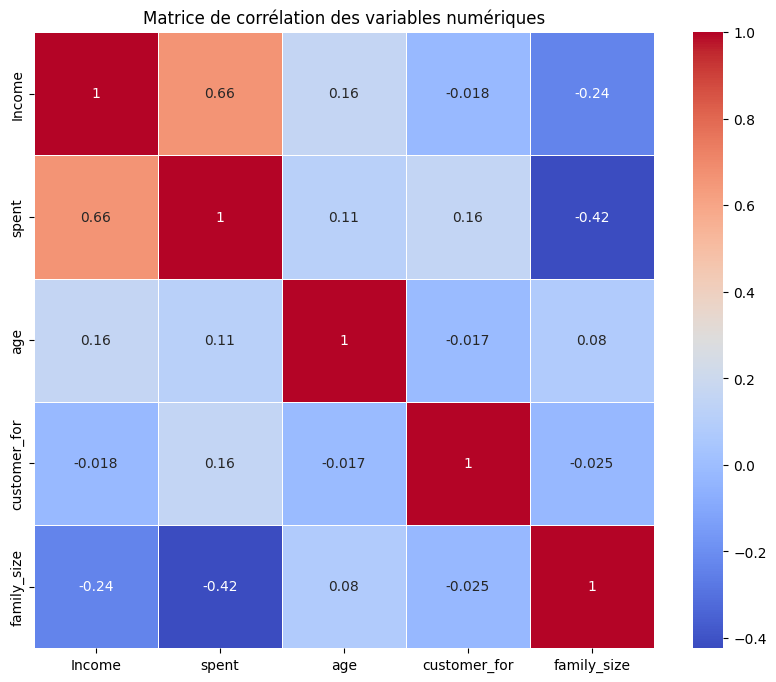

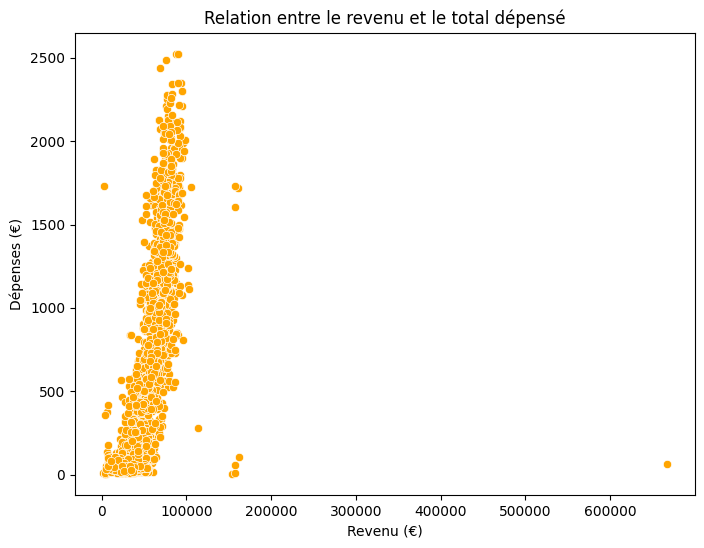

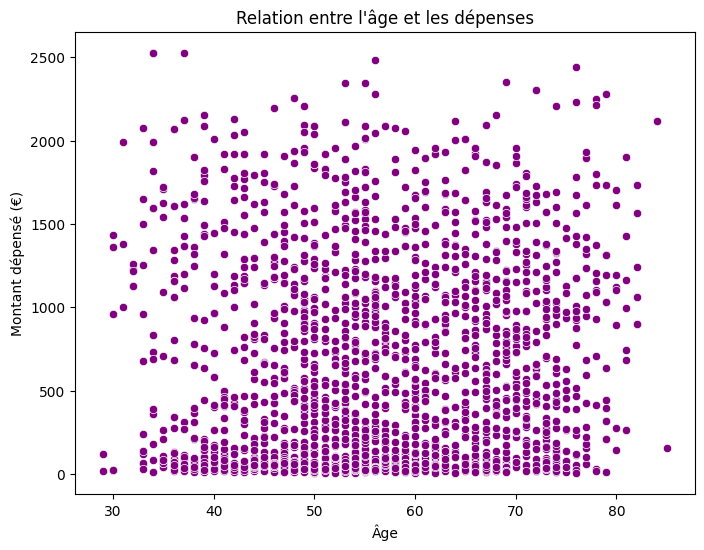

In [ ]:
#Age
plt.figure(figsize=(10,6))
df['age'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution de l'âge des clients")
plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.show()

#Revenu
plt.figure(figsize=(10,6))
sns.histplot(df['Income'], bins=30, kde=True, color='lightgreen')
plt.title("Distribution du revenu des clients")
plt.xlabel("Revenu")
plt.ylabel("Nombre de clients")
plt.show()

#Dépenses (spent)
plt.figure(figsize=(10,6))
sns.histplot(df['spent'], bins=30, kde=True, color='coral')
plt.title("Distribution du total dépensé sur 2 ans")
plt.xlabel("Montant dépensé (€)")
plt.ylabel("Nombre de clients")
plt.show()

#Corrélations
plt.figure(figsize=(10,8))
corr = df[['Income', 'spent', 'age', 'customer_for', 'family_size']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation des variables numériques")
plt.show()

#Revenu vs Dépenses
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='spent', data=df, color='orange')
plt.title("Relation entre le revenu et le total dépensé")
plt.xlabel("Revenu (€)")
plt.ylabel("Dépenses (€)")
plt.show()


#Âge vs Dépenses
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='spent', data=df, color='purple')
plt.title("Relation entre l'âge et les dépenses")
plt.xlabel("Âge")
plt.ylabel("Montant dépensé (€)")
plt.show()


### 📊 Synthèse des analyses exploratoires

L’analyse exploratoire met en évidence plusieurs tendances clés dans le comportement et le profil des clients :

- **Âge :** la majorité des clients ont entre **40 et 70 ans**, ce qui indique une clientèle **mature et stable financièrement**.  
- **Revenu :** la distribution est **asymétrique à droite**, avec une majorité de foyers gagnant moins de **100 000 €** et quelques **revenus très élevés**.  
  Cela traduit une **forte disparité économique** entre les clients.  
- **Dépenses (Spent) :** les montants dépensés varient fortement, suggérant l’existence de **segments de clients plus dépensiers**.  
- **Situation familiale :** les clients vivant en couple ont tendance à **dépenser davantage**, probablement en raison de revenus cumulés ou de dépenses partagées.  
- **Niveau d’éducation :** les individus avec un niveau d’études plus élevé montrent une **propension à la dépense légèrement supérieure**.  

En résumé, la base de clients est **diversifiée**, avec un **noyau principal d’adultes actifs et aisés**, mais aussi des écarts de revenus et de comportements d’achat.  
Ces constats orientent vers une **segmentation marketing** différenciée selon **l’âge, le revenu et le mode de vie**.


# 4. Feature Engineering
## Fonctions utilitaires

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def detect_sep(path: Path) -> str:
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        lines = [f.readline() for _ in range(5)]
    candidates = [",", ";", "\t", "|"]
    best, best_count = ",", -1
    for sep in candidates:
        c = sum(line.count(sep) for line in lines if line)
        if c > best_count:
            best_count, best = c, sep
    return best

def ensure_dir(d: Path) -> Path:
    d.mkdir(parents=True, exist_ok=True)
    return d

def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def save_table(df: pd.DataFrame, outdir: Path, name: str):
    p = outdir / f"{name}.csv"
    df.to_csv(p, index=False)
    print(f"[CSV] {p}")
    return p

def save_fig(outdir: Path, name: str):
    p = outdir / f"{name}.png"
    plt.tight_layout()
    plt.savefig(p, dpi=140)
    print(f"[PNG] {p}")


### 🔹 Simplification et transformation des variables

Ces fonctions transforment certaines colonnes pour les rendre plus exploitables :
- **`simplify_marital_status`** : regroupe les statuts maritaux en *couple* / *célibataire*,
- **`simplify_education`** : regroupe les niveaux d’éducation,
- **`add_missing_features`** : crée de nouvelles variables utiles (`age`, `spent`, `is_parent`, etc.).


In [ ]:
def simplify_marital_status(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower()
    return "couple" if x in {"married","together","union","in relationship"} else "célibataire"

def simplify_education(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower()
    if x in {"master","phd","postgraduate"}: return "postgrad"
    if x in {"graduation","graduate","college","bachelor"}: return "grad"
    return "undergrad"

def add_missing_features(df: pd.DataFrame) -> pd.DataFrame:
    if "Dt_Customer" in df.columns:
        df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors="coerce", dayfirst=True)
    if "age" not in df.columns and "Year_Birth" in df.columns:
        df["age"] = 2025 - to_num(df["Year_Birth"])
    if "spent" not in df.columns:
        mnt_cols = [c for c in df.columns if c.lower().startswith("mnt")]
        if mnt_cols:
            df["spent"] = df[mnt_cols].apply(to_num).sum(axis=1)
    if "living_with" not in df.columns and "Marital_Status" in df.columns:
        df["living_with"] = df["Marital_Status"].apply(simplify_marital_status)
    if "education2" not in df.columns and "Education" in df.columns:
        df["education2"] = df["Education"].apply(simplify_education)
    if "is_parent" not in df.columns and {"Kidhome","Teenhome"}.issubset(df.columns):
        df["children"] = to_num(df["Kidhome"]).fillna(0) + to_num(df["Teenhome"]).fillna(0)
        df["is_parent"] = (df["children"] > 0).astype(int)
    if "Response" in df.columns and not pd.api.types.is_numeric_dtype(df["Response"]):
        df["Response"] = to_num(df["Response"])
    return df


## Nettoyage des colonnes inutiles avant PCA

In [2]:
import pandas as pd

# Charger ton fichier Excel initial (celui que tu as utilisé au début)
df = pd.read_excel("Market_filled.xlsx")

print("✅ Dataset original chargé avec succès :", df.shape)
display(df.head())

df_reduit = df.copy()
colonnes_a_supprimer = ["ID", "Year_Birth", "Kidhome", "Teenhome", "Z_CostContact", "Z_Revenue", "Dt_Customer"]
df_reduit = df_reduit.drop(columns=colonnes_a_supprimer, errors='ignore')
print("✅ Nouvelles dimensions du dataset :", df_reduit.shape)
display(df_reduit.head())

# 🔹 Sauvegarde du dataset réduit
df_reduit.to_excel("Market_reduit.xlsx", index=False)
print("✅ Fichier 'Market_reduit.xlsx' enregistré avec succès !")




✅ Dataset original chargé avec succès : (2237, 37)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_Revenue,Response,age,spent,children,family_size,living_with,is_parent,education2,customer_for
0,5524,1957,Graduation,Single,58138.0,0,0,1346716800000000000,58,635,...,11,1,68,1617,0,1,Single,0,Graduate,663
1,2174,1954,Graduation,Single,46344.0,1,1,1394236800000000000,38,11,...,11,0,71,27,2,3,Single,1,Graduate,113
2,4141,1965,Graduation,Together,71613.0,0,0,1377043200000000000,26,426,...,11,0,60,776,0,2,Partner,0,Graduate,312
3,6182,1984,Graduation,Together,26646.0,1,0,1391990400000000000,26,11,...,11,0,41,53,1,3,Partner,1,Graduate,139
4,5324,1981,PhD,Married,58293.0,1,0,1390089600000000000,94,173,...,11,0,44,422,1,3,Partner,1,Postgraduate,161


✅ Nouvelles dimensions du dataset : (2237, 30)


,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Complain,Response,age,spent,children,family_size,living_with,is_parent,education2,customer_for
0,Graduation,Single,58138.0,58,635,88,546,172,88,88,...,0,1,68,1617,0,1,Single,0,Graduate,663
1,Graduation,Single,46344.0,38,11,1,6,2,1,6,...,0,0,71,27,2,3,Single,1,Graduate,113
2,Graduation,Together,71613.0,26,426,49,127,111,21,42,...,0,0,60,776,0,2,Partner,0,Graduate,312
3,Graduation,Together,26646.0,26,11,4,20,10,3,5,...,0,0,41,53,1,3,Partner,1,Graduate,139
4,PhD,Married,58293.0,94,173,43,118,46,27,15,...,0,0,44,422,1,3,Partner,1,Postgraduate,161


✅ Fichier 'Market_reduit.xlsx' enregistré avec succès !


### 
Les variables Year_Birth, Kidhome, Teenhome, Z_CostContact et Z_Revenue ont été supprimées afin d’optimiser la qualité du dataset.
Cette opération vise à réduire la redondance et à éliminer les variables peu explicatives, ce qui améliore la pertinence statistique des analyses futures, notamment pour la PCA et le clusterin

### 🔹 Matrice de corrélation




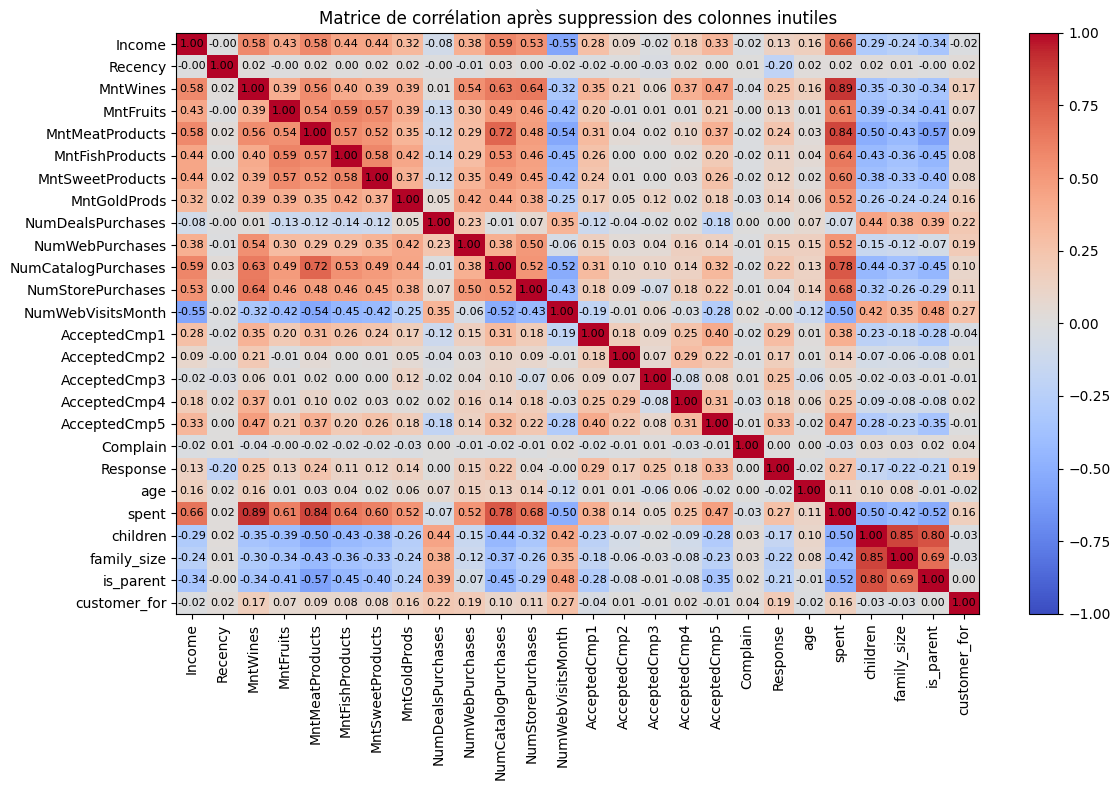

In [3]:

import matplotlib.pyplot as plt
import numpy as np
df_num_reduit = df_reduit.select_dtypes(include=np.number).dropna()
corr = df_num_reduit.corr()
plt.figure(figsize=(12, 8))
plt.imshow(corr.values, aspect='auto', cmap="coolwarm", vmin=-1, vmax=1)

plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.columns)), labels=corr.columns)
plt.title("Matrice de corrélation après suppression des colonnes inutiles")
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.values[i, j]:.2f}", 
                 ha='center', va='center', color='black', fontsize=8)

plt.colorbar()
plt.tight_layout()
plt.show()



### 
Après suppression des variables inutiles (ID, Year_Birth, Kidhome, Teenhome, Z_CostContact, Z_Revenue, Dt_Customer), la matrice montre des corrélations plus claires et cohérentes.
Les montants dépensés dans les différents produits sont fortement liés entre eux et modérément corrélés au revenu, ce qui confirme que les clients à revenu élevé dépensent davantage.
Les variables familiales restent peu corrélées, indiquant un impact limité sur le comportement d’achat.

# 4. PCA : analyse de la variance expliquée

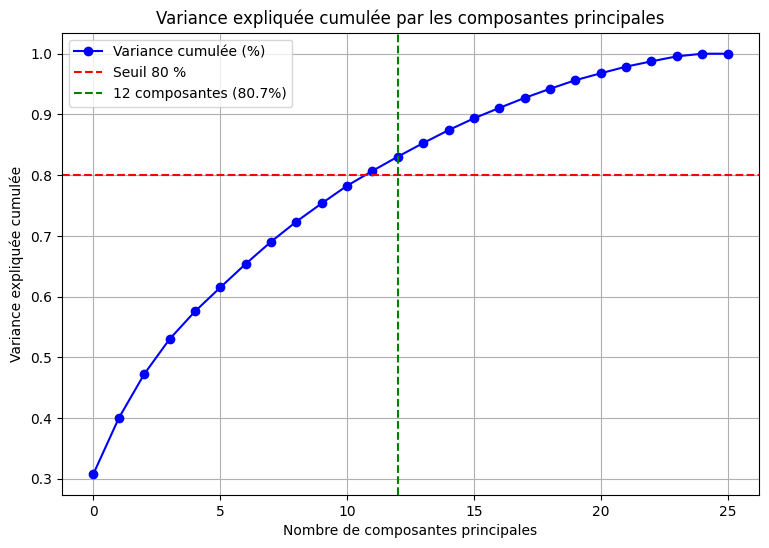

✅ Pour atteindre 80 % de la variance, il faut 12 composantes principales.
🎯 Ces 12 composantes expliquent 80.71% de la variance totale.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
df_num = df_reduit.select_dtypes(include=np.number).dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
seuil = 0.80
n_components_80 = np.argmax(cumulative_variance >= seuil) + 1

plt.figure(figsize=(9, 6))
plt.plot(cumulative_variance, marker='o', color='b', label="Variance cumulée (%)")
plt.axhline(y=seuil, color='r', linestyle='--', label='Seuil 80 %')
plt.axvline(x=n_components_80, color='g', linestyle='--', label=f"{n_components_80} composantes ({cumulative_variance[n_components_80-1]*100:.1f}%)")

plt.title("Variance expliquée cumulée par les composantes principales")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Pour atteindre 80 % de la variance, il faut {n_components_80} composantes principales.")
print(f"🎯 Ces {n_components_80} composantes expliquent {cumulative_variance[n_components_80-1]*100:.2f}% de la variance totale.")


### Entrainement sur PCA=3

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

df_num = df_reduit.select_dtypes(include='number').dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

pca_final = PCA(n_components=3)
X_pca3 = pca_final.fit_transform(X_scaled)

df_pca3 = pd.DataFrame(
    X_pca3,
    columns=['PCA1', 'PCA2', 'PCA3']
)

print("✅ Réduction terminée : données projetées sur 3 composantes principales.")
print(f"Variance expliquée par les 3 composantes : {sum(pca_final.explained_variance_ratio_)*100:.2f}%")
display(df_pca3.head())


✅ Réduction terminée : données projetées sur 3 composantes principales.
Variance expliquée par les 3 composantes : 47.25%


,PCA1,PCA2,PCA3
0,4.772435,0.424054,-0.365262
1,-2.755988,-0.482106,-0.175692
2,2.072036,-0.796514,-0.996663
3,-2.605991,-1.153589,0.139719
4,-0.635971,0.487358,-1.024598


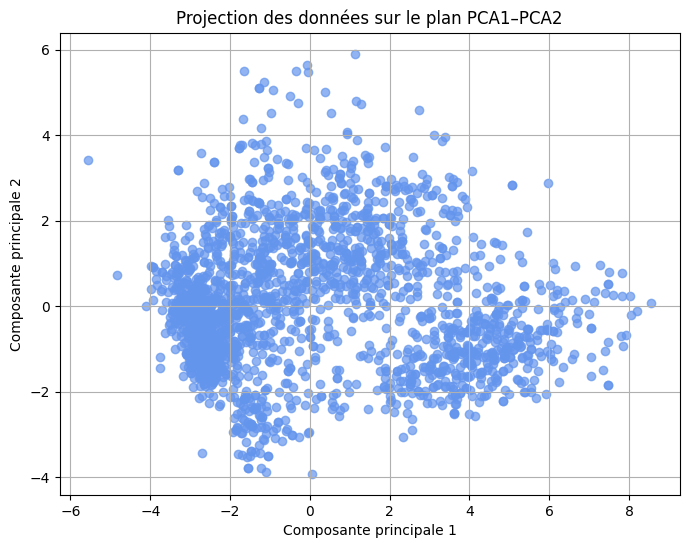

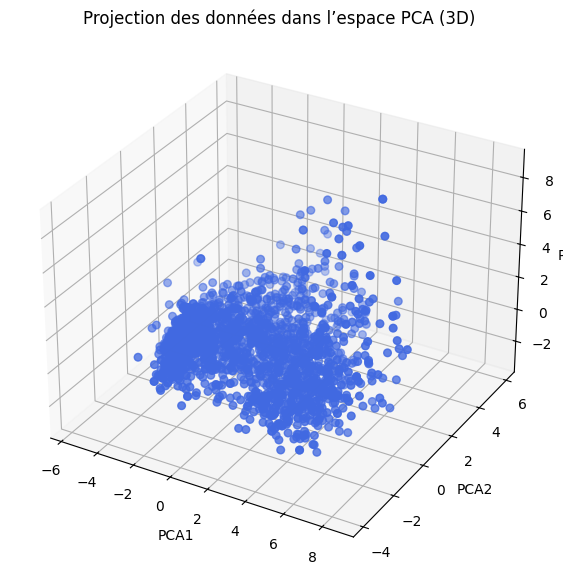

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import seaborn as sns

#  Graphique 2D : PCA1 vs PCA2
plt.figure(figsize=(8,6))
plt.scatter(df_pca3["PCA1"], df_pca3["PCA2"], alpha=0.7, color='cornflowerblue')
plt.title("Projection des données sur le plan PCA1–PCA2")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

# Graphique 3D : PCA1, PCA2, PCA3
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca3["PCA1"], df_pca3["PCA2"], df_pca3["PCA3"], c='royalblue', s=30)
ax.set_title("Projection des données dans l’espace PCA (3D)")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
plt.show()



## 
Les graphiques PCA montrent une dispersion homogène des individus, avec des regroupements potentiels visibles sur les axes principaux.
Ces observations suggèrent qu’un clustering (K-Means) pourrait permettre d’identifier des profils clients distincts.

# 5. Clustering: K-Means

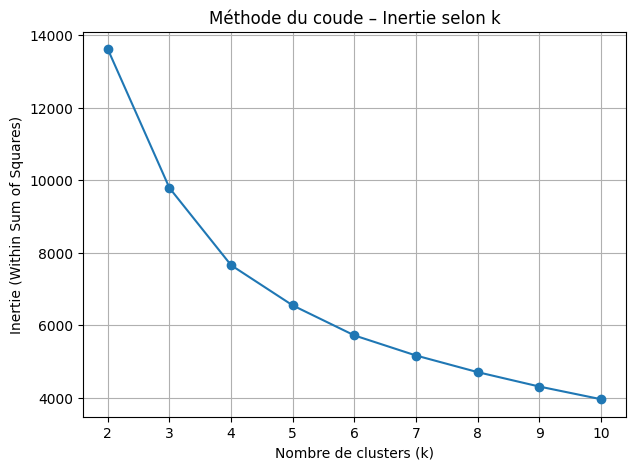

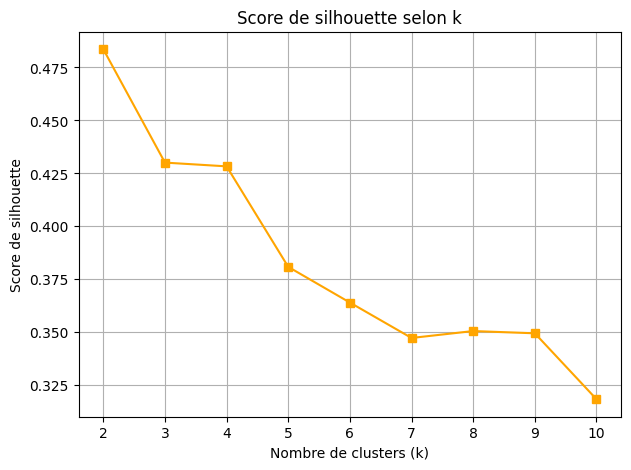

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouettes = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeans.fit(df_pca3)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df_pca3, kmeans.labels_))

# Méthode du coude
plt.figure(figsize=(7,5))
plt.plot(K, inertias, marker='o')
plt.title("Méthode du coude – Inertie selon k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (Within Sum of Squares)")
plt.grid(True)
plt.show()

# Score de silhouette
plt.figure(figsize=(7,5))
plt.plot(K, silhouettes, marker='s', color='orange')
plt.title("Score de silhouette selon k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.grid(True)
plt.show()


### 
le modèle K-Means avec k = 3 est retenu comme la meilleure option pour représenter la diversité des comportements clients.
Ces trois clusters serviront de base pour l’analyse et l’interprétation des profils dans la suite du projet.

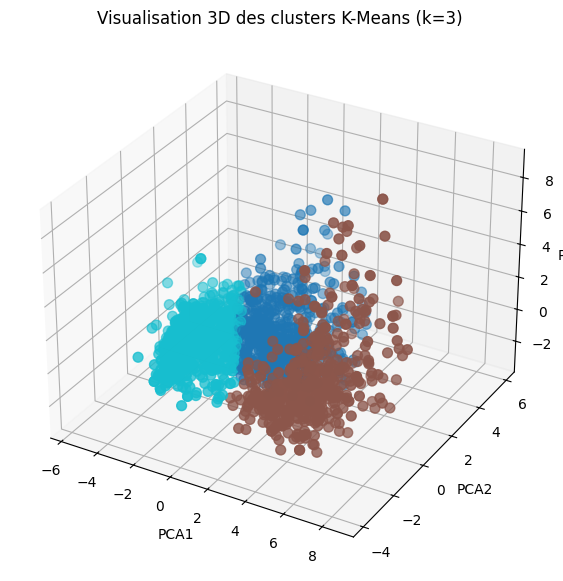

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca3["PCA1"], df_pca3["PCA2"], df_pca3["PCA3"], c=df_pca3["Cluster"], cmap="tab10", s=50)
ax.set_title(f"Visualisation 3D des clusters K-Means (k={best_k})")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
plt.show()


## Visualisation des clusters en 3D

In [ ]:
from sklearn.cluster import KMeans
import plotly.express as px

best_k = 3
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
df_pca3["Cluster"] = kmeans.fit_predict(df_pca3)

fig = px.scatter_3d(
    df_pca3,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    color=df_pca3["Cluster"].astype(str),
    title=f"Visualisation 3D des clusters K-Means (k={best_k})",
    opacity=0.8
)

fig.update_traces(marker=dict(size=6))
fig.update_layout(
    scene=dict(
        xaxis_title="PCA1",
        yaxis_title="PCA2",
        zaxis_title="PCA3"
    ),
    legend_title_text="Cluster"
)

fig.show()




### 
On distingue clairement trois groupes distincts, confirmant la validité du modèle K-Means avec k = 3.

Chaque cluster regroupe des clients présentant des caractéristiques et comportements similaires.

Les distances entre les groupes indiquent une bonne séparation : les clients d’un même cluster partagent des profils homogènes.

Cette segmentation visuelle permettra ensuite d’analyser les profils moyens de chaque cluster (revenu, dépenses, âge, etc.) afin de définir des stratégies marketing ciblées.

## Analyse descriptive par cluster

In [ ]:

df_clusters = pd.concat([df_reduit.reset_index(drop=True), df_pca3["Cluster"]], axis=1)
cluster_summary = df_clusters.groupby("Cluster").mean(numeric_only=True).round(2)

print("📊 Profil moyen des clusters :")
display(cluster_summary)
cluster_counts = df_clusters["Cluster"].value_counts().sort_index()
print("\n📦 Nombre d'individus par cluster :")
display(cluster_counts)


📊 Profil moyen des clusters :


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,Complain,Response,age,spent,children,family_size,is_parent,customer_for
Cluster,,,,,,,,,,,,,,,,,,,,,
0,61363.61,49.90,494.04,31.53,168.54,41.30,32.70,68.34,3.87,6.61,...,0.13,0.02,0.01,0.12,59.48,836.47,1.22,2.90,0.98,418.58
1,76160.33,49.07,623.37,65.33,470.10,97.35,67.63,75.71,1.09,5.03,...,0.14,0.29,0.00,0.32,56.67,1399.49,0.07,1.65,0.07,352.13
2,36294.56,48.70,54.48,5.43,26.24,7.90,5.34,16.22,2.07,2.29,...,0.01,0.00,0.01,0.08,54.01,115.60,1.22,2.87,0.87,319.70



📦 Nombre d'individus par cluster :


Cluster
0     602
1     516
2    1119
Name: count, dtype: int64

### 
Les clusters sont bien différenciés par le revenu et le niveau de dépenses.

Le cluster 1 regroupe les clients à fort potentiel, le cluster 0 représente une clientèle équilibrée, et le cluster 2 un segment à faible engagement.

Cette segmentation permet à l’entreprise d’adopter une stratégie marketing ciblée et différenciée selon les besoins et comportements de chaque groupe.

C:\Users\khoul\AppData\Local\Temp\ipykernel_21400\822083183.py:9: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



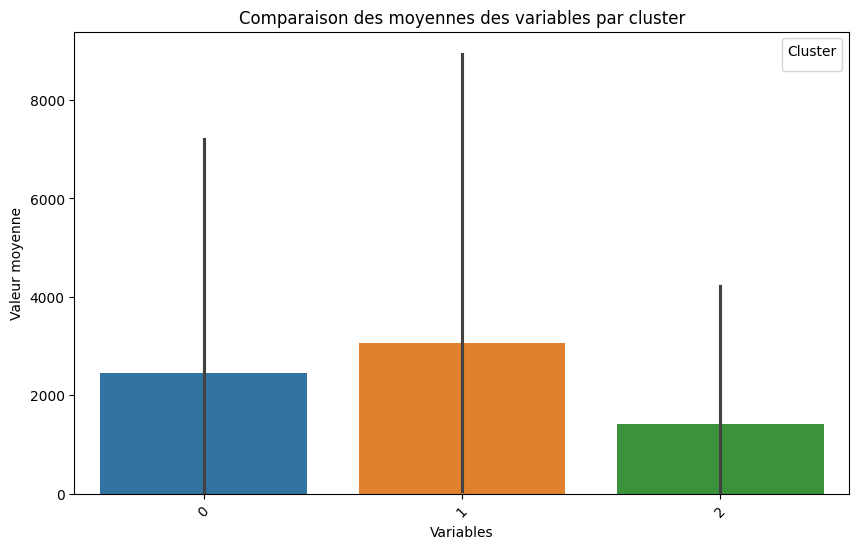

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=cluster_summary.T)
plt.title("Comparaison des moyennes des variables par cluster")
plt.ylabel("Valeur moyenne")
plt.xlabel("Variables")
plt.legend(title="Cluster")
plt.xticks(rotation=45)
plt.show()


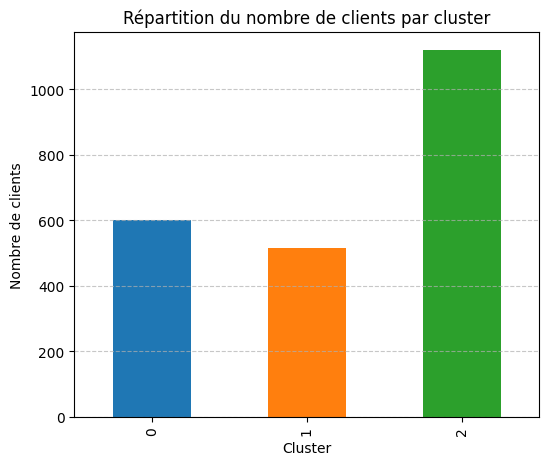

In [12]:
plt.figure(figsize=(6,5))
df_pca3["Cluster"].value_counts().sort_index().plot(kind='bar', color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.title("Répartition du nombre de clients par cluster")
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###
Cluster 1 → fidélisation et offres exclusives,
Cluster 0 → maintien de la relation et ventes croisées,
Cluster 2 → campagnes promotionnelles pour stimuler l’achat.

C:\Users\khoul\AppData\Local\Temp\ipykernel_21400\1341107541.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




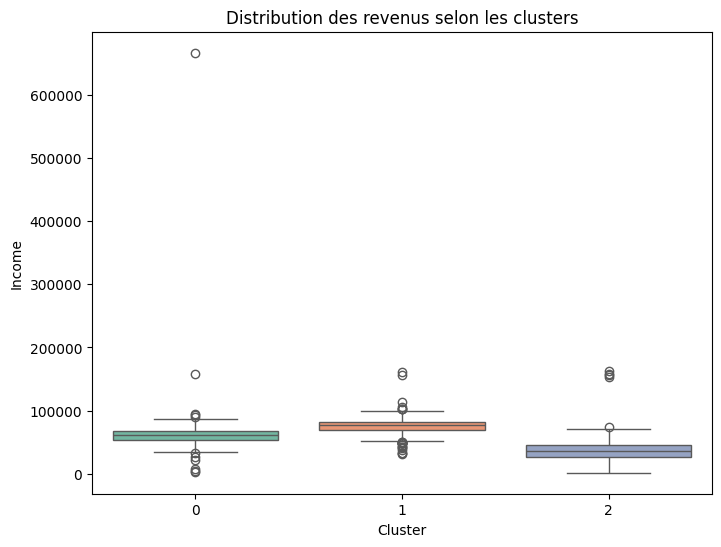

C:\Users\khoul\AppData\Local\Temp\ipykernel_21400\1341107541.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




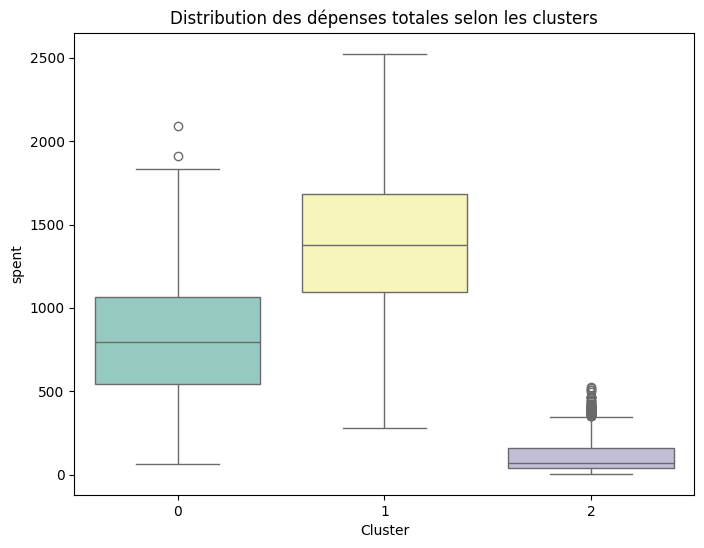

In [13]:
df_clusters["spent"] = df_clusters[[c for c in df_clusters.columns if c.startswith("Mnt")]].sum(axis=1)
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Income", data=df_clusters, palette="Set2")
plt.title("Distribution des revenus selon les clusters")
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="spent", data=df_clusters, palette="Set3")
plt.title("Distribution des dépenses totales selon les clusters")
plt.show()


### 
Le revenu et la dépense totale sont fortement corrélés : plus le revenu est élevé, plus la dépense moyenne augmente.
On distingue trois segments socio-économiques clairs :
Cluster 1 : clientèle haut de gamme, rentable et fidèle.
Cluster 0 : clientèle intermédiaire, stable et régulière.
Cluster 2 : clientèle modeste, peu consommatrice.